In [1]:
%env CUDA_VISIBLE_DEVICES=0,2,3
%env LIBRARY_PATH=/usr/local/cuda/lib64
import sys
sys.path.append(os.path.expanduser("~/.local/lib/python3.6/site-packages/"))

env: CUDA_VISIBLE_DEVICES=0,2,3
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [2]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [3]:
import h5py
import torch
import cv2

/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [5]:
def get_flow(capture, name, train_photo_folder, frames_per_video=30):
    ret, frame1 = capture.read()
    prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255    
    
    frames = list()
    flow_img = list()

    while(1):
        ret, frame2 = capture.read()
        if not ret: break
        frames.append(frame2) 

    frames_ind = np.random.choice(len(frames), replace=False, size=frames_per_video)
    np.save(os.path.join(train_photo_folder, name), np.array(frames)[frames_ind])

In [6]:
train_video_path = os.path.expanduser("~/data/Images_2_data/HW_3_data/{0}_video/action-recognition-{0}/"
                                      .format("train"))

In [7]:
train_photo_folder = os.path.expanduser("~/data/Images_2_data/HW_3_data/{0}_frames".format("train"))

In [8]:
def make_frame_crops(train_photo_folder):
    video_names = os.listdir(train_video_path)
    for index, name in enumerate(video_names):
        capture = cv2.VideoCapture(os.path.join(train_video_path, name))
        get_flow(capture, name.split(".")[0], train_photo_folder)
        if not index % 100:
            print(index)

In [9]:
%%time
make_frame_crops(train_photo_folder)

In [10]:
#plt.imshow(np.load(train_photo_folder + "/8616.npy")[0][..., ::-1])

## PyTorch data loaders

In [11]:
from torch.utils.data import Dataset 
from PIL import Image
import random
from torchvision import transforms

In [12]:
class MyDataset(Dataset):
    def __init__(self, data_paths, transform_X=None, answers=None, train=True, pack=5):
        self.data_paths = data_paths
        self.transform_X = transform_X
        self.answers = answers
        self.train = train
        self.pack = pack
    
    def __getitem__(self, index):
        image_pack = np.load(self.data_paths[index])[..., ::-1]
        if self.train:
            image_pack = image_pack[np.random.choice(range(len(image_pack)), size=self.pack, replace=False)]
        transformed_images = []
        if self.transform_X:
            transformed_images = [self.transform_X(Image.fromarray(x)) for x in image_pack]
        video_id = self.data_paths[index].split("/")[-1].split(".")[0] + '.avi'
        
        if self.answers:
            y = self.answers[video_id]
            return transformed_images, y 
        else:
            return transformed_images

    def __len__(self):
        return len(self.data_paths)

In [13]:
import csv
train_paths = [os.path.join(train_photo_folder, file) for file in os.listdir(train_photo_folder)]

answers = {}
with open(os.path.expanduser("~/data/Images_2_data/HW_3_data/train_gt.csv"), 'r') as f:
    reader = csv.reader(f)
    next(reader, None)
    for row in csv.reader(f):
        answers[row[0]] = int(row[1])

In [14]:
from sklearn.cross_validation import train_test_split
files = np.array([file for file in os.listdir(train_photo_folder)])

train_paths, val_paths = train_test_split(files, train_size = 0.9, random_state=1543)


train_paths = [os.path.join(train_photo_folder, file) for file in train_paths]
val_paths = [os.path.join(train_photo_folder, file) for file in val_paths]

/home/shirobokov/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
batch_size = 32#64

transform_X_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = MyDataset(train_paths, transform_X=transform_X_train, answers=answers)

train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

transform_X_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_dataset = MyDataset(val_paths, transform_X=transform_X_val, answers=answers, train=True)

val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=1)

In [16]:
len(val_batch_gen), len(train_batch_gen)

(30, 267)

In [17]:
for (x_batch, y_batch) in val_batch_gen:
#     plt.imshow((np.array([x[0].numpy() for x in x_batch])[4] * np.array([0.229, 0.224, 0.225])[:, None, None] + 
#                 np.array([0.485, 0.456, 0.406])[:, None, None]).transpose(1,2,0))
    break

In [18]:
# plt.imshow((np.array([x[0].numpy() for x in x_batch])[29] * np.array([0.229, 0.224, 0.225])[:, None, None] + 
#             np.array([0.485, 0.456, 0.406])[:, None, None]).transpose(1,2,0))

## Spatial network

In [20]:
import torchvision.models as models
net = models.resnet101(pretrained=True)
net.fc = nn.Linear(2048, 101, bias=True)
net = net.cuda()
net = nn.DataParallel(net)

In [22]:
def get_output(net, X_batch, train=True):
    video_index = len(X_batch)
    batch_size = X_batch[0].shape[0]
    input_stacked = torch.transpose(torch.stack([x for x in X_batch]), 1, 0).contiguous()
    input_stacked = input_stacked.view(input_stacked.shape[0] * input_stacked.shape[1], 3, 224, 224)
    if train:
        output = net(Variable(input_stacked).cuda())
    else:
        output = net(Variable(input_stacked, volatile=True).cuda())
    return torch.stack([output[index * video_index : video_index * (index + 1), :].mean(dim=0)
                       for index in range(batch_size)])

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=-1).reshape(-1,1)

In [23]:
import time
from pandas import ewma
from IPython import display
from sklearn.metrics import accuracy_score        

opt = torch.optim.Adam(net.parameters(), lr=1e-4)

num_epochs = 2

train_loss = []
val_accuracy = []

In [52]:
opt = torch.optim.Adam(net.parameters(), lr=1e-5)

In [58]:
num_epochs = 5

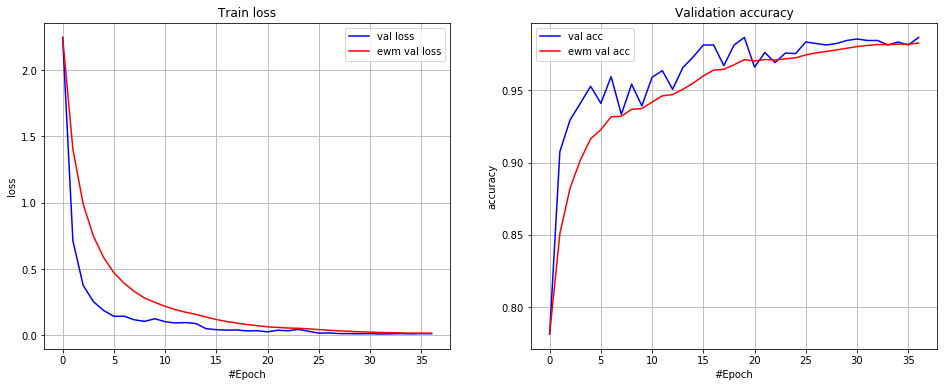

Epoch 5 of 5 took 701.538s
  training loss (in-iteration): 	0.012475
  validation acc:		0.986458


In [ ]:
for epoch in range(num_epochs):
    start_time = time.time()
    
    net.train()
    start_time = time.time()
    loss_batch = []
    inner_batch_counter = 0
    for (X_batch, y_batch) in train_batch_gen:
        # train on batch
        logits = get_output(net, X_batch)
        y_batch = Variable(y_batch).cuda()

        loss = F.cross_entropy(logits, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        loss_batch.append(loss.data.cpu().numpy()[0])
        
        inner_batch_counter += 1
        if not inner_batch_counter % 25:
            print(inner_batch_counter)
    train_loss.append(np.mean(loss_batch))
    
    print("Eval:------------")
    net.eval()
    val_acc = []
    for (X_batch, y_batch) in val_batch_gen:
        logits = get_output(net, X_batch, train=False)
        y_pred = logits.data.cpu().numpy()
        prob_batch = softmax(logits.data.cpu().numpy()).argmax(axis=-1)
        val_acc.append(accuracy_score(y_batch.numpy(), prob_batch))
    val_accuracy.append(np.mean(val_acc))
        
    display.clear_output(wait=True)
    #plt.figure(figsize=(8, 6))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    ax1.set_title("Train loss")
    ax1.set_xlabel("#Epoch")
    ax1.set_ylabel("loss")
    ax1.plot(train_loss, 'b',label='val loss')
    ax1.plot(ewma(np.array(train_loss), span=10),'r',label='ewm val loss')
    ax1.legend(loc='best')
    ax1.grid()
    
    ax2.set_title("Validation accuracy")
    ax2.set_xlabel("#Epoch")
    ax2.set_ylabel("accuracy")
    ax2.plot(val_accuracy, 'b',label='val acc')
    ax2.plot(ewma(np.array(val_accuracy), span=10),'r',label='ewm val acc')
    ax2.legend(loc='best')
    ax2.grid()    
    
    plt.show() 

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_loss[-1]))
#     print("  validation accuracy: \t\t\t{:.2f} %".format(
#         np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))
    print("  validation acc:\t\t{:.6f}".format(val_accuracy[-1]))

In [61]:
# net.eval()

In [62]:
# with open (os.path.expanduser("~/data/Images_2_data/HW_3_data/resnet101_36_epochs.pt"), 'wb') as f:
#     torch.save(net, f)

In [29]:
# with open (os.path.expanduser("~/data/Images_2_data/HW_3_data/resnet18_25_epochs.pt"), 'rb') as f:
#     kek = torch.load(f)

## Load test data and evaluate

In [63]:
test_photo_folder = os.path.expanduser("~/data/Images_2_data/HW_3_data/{0}_frames".format("test"))

test_paths = [os.path.join(test_photo_folder, file) for file in os.listdir(test_photo_folder)]

In [64]:
test_dataset = MyDataset(test_paths, transform_X=transform_X_val, answers=None, train=True)

test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=1)

In [65]:
net.eval()
val_acc = []
for X_batch in test_batch_gen:
    logits = get_output(net, X_batch, train=False)
    y_pred = logits.data.cpu().numpy()
    prob_batch = softmax(logits.data.cpu().numpy()).argmax(axis=-1)
    val_acc.append(prob_batch)

In [66]:
test_answers = []
for value in val_acc:
    test_answers.extend(list(value))

In [67]:
len(test_answers)

3729

In [68]:
import pandas as pd

In [69]:
test_keys = [path.split("/")[-1][:-3] + "avi" for path in  test_paths]

In [70]:
test_dataframe = pd.DataFrame({"filename":test_keys,
                               "classnum":test_answers}, columns =("filename", "classnum"))

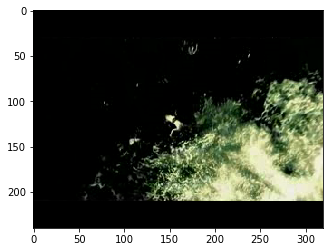

In [38]:
plt.imshow(np.load(test_photo_folder + "/2960.npy")[5][..., ::-1])

In [39]:
# for key, value in answers.items():
#     if value == 21:
#         print(key)
#         break

0029.avi


In [72]:
test_dataframe.to_csv("test_ans.csv", index=False)

### Summary

I used ResNet101 Pretrained on Imagenet, with only laster layer substituted. I tranined net by randomly picking 5 frames from video, with small data augmentation - changing aspect ratio and taking random crop. The net was trained with learning rate decay(1e-4, 1e-4/2, 1e-5) and optimizer restarts. The training took about a day.
I did not use optical flow. Since I know, that it should increase the accuracy(up to 82 standalone and 86 with combination of usual images), but it will be even more time consuming to train two networks.